<a href="https://colab.research.google.com/github/hojin99/aitest/blob/main/%EC%8B%AC%EC%B8%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D_%ED%9B%88%EB%A0%A8%EB%B0%A9%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf

# 실행 마다 랜덤값이 동일하게 나오도록 설정
tf.keras.utils.set_random_seed(42)
# 동일 하드웨어에서 여러번 실행 시 동일한 결과가 나오도록 함 (디버깅 시 필요)
# 병렬 처리등 비결정적인 부분을 결정적으로 실행하기 때문에 속도가 느려질 수 있기 때문에 실전에서는 권장 안함
tf.config.experimental.enable_op_determinism()

In [8]:
from tensorflow import keras

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [9]:
from sklearn.model_selection import train_test_split

train_scaled = train_input /255.0 # 이미지 데이터의 경우 최대값이 255여서 255로 나누어도 정규화가 됨
# print(train_scaled[:10])

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [10]:
def model_fn(drop_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28)))  
  model.add(keras.layers.Dense(100, activation='relu'))
  if drop_layer:
    model.add(drop_layer) 
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model


### 훈련 히스토리 보기 (손실곡선)

In [ ]:
model = model_fn()
model.summary()

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20)

Epoch 1/20
1500/1500 [==============================] - 6s 3ms/step - loss: 0.2935 - accuracy: 0.8907
Epoch 2/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2799 - accuracy: 0.8968
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2671 - accuracy: 0.9008
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2611 - accuracy: 0.9034
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2491 - accuracy: 0.9070
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2420 - accuracy: 0.9102
Epoch 7/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2347 - accuracy: 0.9122
Epoch 8/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2274 - accuracy: 0.9151
Epoch 9/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2204 - accuracy: 0.9177
Epoch 10/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.212

In [7]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


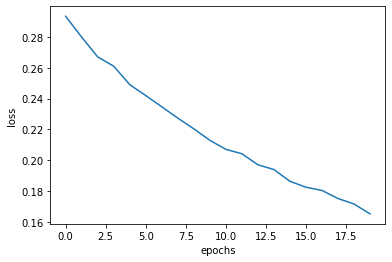

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

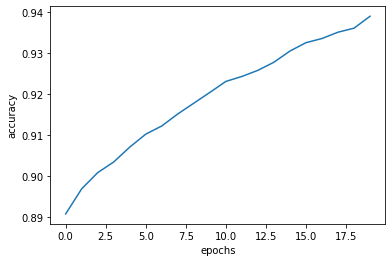

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

### 검증 손실 확인

In [19]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

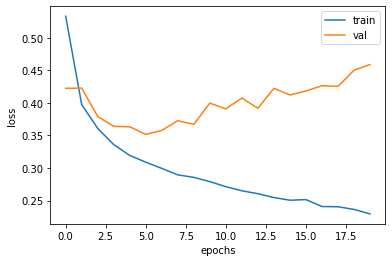

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

### Dropout (규제)

In [11]:
from tensorflow import keras

model = model_fn(keras.layers.Dropout(0.3))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

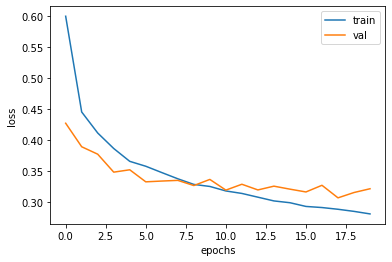

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

### 모델 저장 및 복원

In [17]:
model.save('model-whole.h5') # 모델 저장
model.save_weights('model-weights.h5') # 가중치 저장

In [18]:
!ls -al 

total 1304
drwxr-xr-x 1 root root   4096 Nov 13 04:35 .
drwxr-xr-x 1 root root   4096 Nov 13 04:24 ..
drwxr-xr-x 4 root root   4096 Nov 10 14:29 .config
-rw-r--r-- 1 root root 333448 Nov 13 04:35 model-weights.h5
-rw-r--r-- 1 root root 982664 Nov 13 04:35 model-whole.h5
drwxr-xr-x 1 root root   4096 Nov 10 14:30 sample_data


In [19]:
# 가중치 복원
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 2s 5ms/step
0.8860833333333333


In [20]:
# 모델 복원
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3219 - accuracy: 0.8861


[0.3219127655029297, 0.8860833048820496]

### 콜백 (자동 저장, 자동 종료)

In [27]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb, early_stopping_cb])

In [28]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3301 - accuracy: 0.8800


[0.3301091492176056, 0.8799999952316284]

In [29]:
print(early_stopping_cb.stopped_epoch)

9


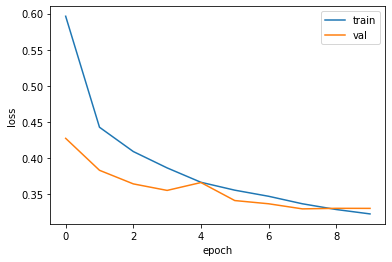

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()